## Normalizing flow demos. 
References:
* https://github.com/acids-ircam/pytorch_flows/blob/master/flows_01.ipynb
* https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
* https://blog.evjang.com/2018/01/nf1.html
* https://blog.evjang.com/2018/01/nf1.html


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torch.distributions.transforms as T
import torch.distributions as D
import torch.nn.functional as F

import torchvision.datasets as dset

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# grid points
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

### Radial flow

In [3]:
class RadialFlow(nn.Module):
    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.alpha = nn.Parameter(torch.Tensor(1))    
        self.dim = dim
        self.init_parameters()
        
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
        
    def forward(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1. / (self.alpha + r)
        return z + self.beta * h * (z - self.z0)
        
    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1. / (self.alpha + r)
        dh = - 1. / ((self.alpha + r) ** 2)
        base = 1 + self.beta * h
        det_grad =  (base + self.beta * dh * r) * base ** (self.dim - 1)
        return torch.log(torch.abs(det_grad) + 1e-9)
        

In [4]:
def change_density(q0_density, flow, z):
    # Apply our transform on coordinates
    f_z = flow(torch.Tensor(z)).detach()
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(z)).detach().squeeze())
    return q1_density, f_z


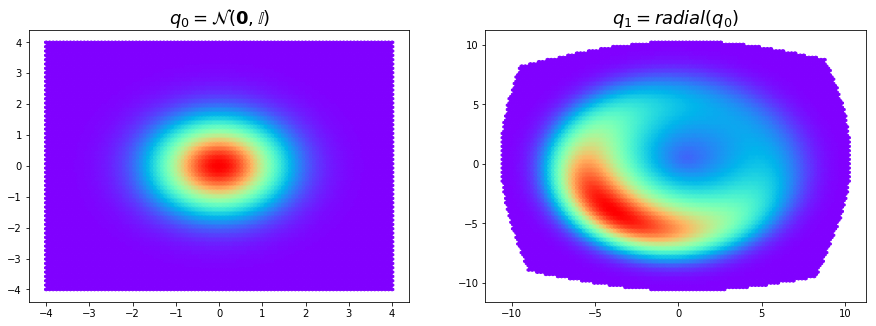

In [14]:
# test
q0 = D.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))

flow = RadialFlow(2)

flow.z0.data = torch.Tensor([[0.5, 0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);

### Invertible generative flows

#### Parametric ReLU flow

In [5]:
# PReLU

class PReLU_Flow(nn.Module):
    def __init__(self, dim):
        super(PReLU_Flow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.init_parameters()
        
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.99)
    
    def forward(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)
    
    def inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)
    
    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_det, dim = 1)

tensor([2.4923e-08, 2.5710e-08, 2.6521e-08,  ..., 7.9651e-09, 7.7194e-09,
        7.4808e-09])
tensor([[-4.3530, -4.3530],
        [-4.3459, -4.3553],
        [-4.3387, -4.3575],
        ...,
        [ 8.8628,  8.8962],
        [ 8.8757,  8.8924],
        [ 8.8887,  8.8887]])


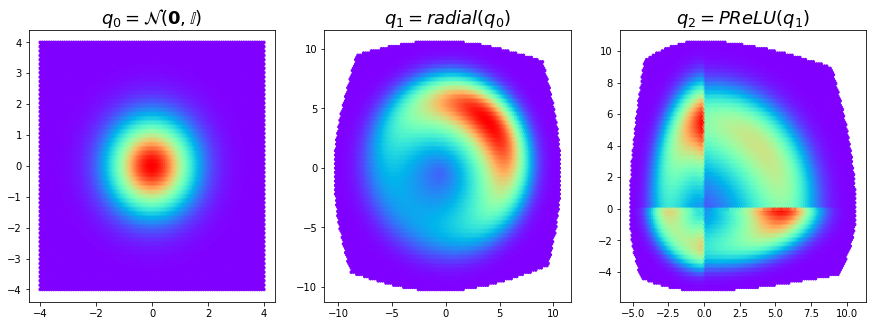

In [24]:
# Our base density
q0 = D.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our radial transform
flow = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.z0.data = torch.Tensor([[-0.5, -0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Our ReLU flow
flow = PReLU_Flow(2) 
# Manually set the transform parameters (dirty again ^^)
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)
print(q2_density)
print(f_z2)
# Plot this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PReLU(q_1)$', fontsize=18);

### Batch normalizing flow

In [6]:
class BatchNormFlow(nn.Module):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def forward(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

### Affine transforms

In [7]:
from scipy import linalg

In [8]:
class AffineLUFlow(nn.Module):
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        P, L, U = linalg.lu(weights.numpy())
        
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        
        # masks to enforce triangular matrices
        self.mask_low = torch.tril(torch.ones_like(weights), -1)
        self.mask_up = torch.triu(torch.ones_like(weights), -1)
        self.I = torch.eye(weights.size(0))
        
        # compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(U)))
        
    def forward(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights
    
    def inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(self.weights)
    
    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)